# №15. Модели ResNet

## 1. Краткая теория

1. [Сравнение YOLO и ResNet в задаче определения предметов на изображении](https://habr.com/ru/articles/761200/#resnet)
2. ...

### 1.1 Проблема деградации глубоких сетей
До появления ***ResNet*** исследователи обнаружили, что в очень глубоких сверточных нейронных сетях (CNN) с добавлением новых слоев точность обучения сначала увеличивается, а затем начинает резко падать. Это явление, известное как проблема деградации, не является следствием переобучения, а вызвано тем, что градиенты при обратном распространении ошибки постепенно затухают (проблема ***исчезающих градиентов***). В результате обучение начальных слоев становится крайне неэффективным.

### 1.2 Архитектура и варианты
Архитектура ***ResNet*** состоит из нескольких остаточных блоков, которые могут быть двух типов: 
- **Базовый блок**: Используется в более мелких версиях, таких как ResNet-18 и ResNet-34. Состоит из двух сверточных слоев с ядром 3x3.
- **Блок-бутылочное горлышко** (*Bottleneck Block*): Применяется в более глубоких версиях (ResNet-50, 101, 152), чтобы сократить вычислительные затраты. Включает сверточные слои 1x1, 3x3 и 1x1, где слои 1x1 уменьшают и затем восстанавливают размерность, а центральный слой 3x3 остается с меньшими измерениями.

***Устройство модели ResNet***
<table>
  <tr>
    <th>Ключевая особенность ResNet <br> - это наличие «<i><b>skip connections</b></i>»</th>
    <th>Архитектура ResNet</th>
  </tr>
  <tr>
    <td><img src="data/my_images/CNN_and_ResNet.png" width="500"></td>
    <td><img src="data/my_images/ResNet_schema.png" width="500"></td>
  </tr>
</table>

### 1.3 Применение ResNet
Благодаря способности эффективно обрабатывать очень глубокие архитектуры, ResNet широко используется во многих задачах компьютерного зрения: 
- **Классификация изображений**: Распознавание объектов на изображениях, например, определение пород животных или марки автомобилей.
- **Обнаружение и сегментация объекто**в: В качестве базовой сети (backbone) в более сложных моделях, таких как Faster R-CNN и Mask R-CNN.
- **Анализ медицинских изображений**: Выявление аномалий на рентгеновских снимках, МРТ и КТ.
- **Автономное вождение**: Обработка данных с камер для обнаружения пешеходов, транспорта и дорожных знаков.
- **Перенос стиля**: Использование для извлечения ключевых визуальных признаков при генерации изображений.
- **Трансферное обучение**: Использование предобученных на ImageNet моделей ResNet для адаптации под другие задачи с небольшим объемом данных. 

## 2. Реализация ResNet

In [9]:
import torch
import torch.nn as nn

### 2.1 Вспомогательные функции (сверточные слои)

In [10]:
# В ResNet используются два данных вида сверточных слоев: с ядрами 3x3 и 1x1
def conv3x3(in_channels:int, out_channels:int, stride:int=1):
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=(3,3),
        stride=stride,
        padding=1,
        bias=False
    )
    
def conv1x1(in_channels:int, out_channels:int, stride:int=1):
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=(1,1),
        stride=stride,
        bias=False
    )

### 2.2 Базовый блок (BasicBlock)

In [11]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels:int, out_channels:int,
                 stride:int=1, downsample=None):
        super().__init__()
        
        self.conv_1 = conv3x3(in_channels, out_channels, stride)
        self.bn_1 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv_2 = conv3x3(out_channels, out_channels)
        self.bn_2 = nn.BatchNorm2d(num_features=out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.conv_1(x)
        out = self.bn_1(out)
        out = self.relu(out)
        
        out = self.conv_2(out)
        out = self.bn_2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out

### 2.3 Блок «Бутылочное горлышко» (Bottleneck)

In [12]:
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_channels:int, out_channels:int,
                 stride:int=1, downsample=None):
        super().__init__()
        self.conv_1 = conv1x1(in_channels, out_channels)
        self.bn_1 = nn.BatchNorm2d(out_channels)
        self.conv_2 = conv3x3(out_channels, out_channels, stride)
        self.bn_2 = nn.BatchNorm2d(out_channels)
        self.conv_3 = conv1x1(out_channels, out_channels * self.expansion)
        self.bn_3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.conv_1(x)
        out = self.bn_1(out)
        out = self.relu(out)
        
        out = self.conv_2(out)
        out = self.bn_2(out)
        out = self.relu(out)
        
        out = self.conv_3(out)
        out = self.bn_3(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out

### 2.4 ResNet Model

In [16]:
class ResNet(nn.Module):
    cfgs: dict[str, tuple[BasicBlock|Bottleneck, list[int]]] = {
        "resnet18": (BasicBlock, [2, 2, 2, 2]), 
        "resnet34": (BasicBlock, [3, 4, 6, 3]), 
        "resnet50": (Bottleneck, [3, 4, 6, 3]), 
        "resnet101": (Bottleneck, [3, 4, 23, 3]), 
        "resnet152": (Bottleneck, [3, 8, 36, 3])
    }

    def __init__(self, name:str, num_classes:int=1000):
        super().__init__()
        block, layers = self.cfgs[name]

        self.inplanes = 64

        self.conv_1 = nn.Conv2d(3, self.inplanes, (7, 7), stride=2, padding=3, bias=False)
        self.bn_1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((3, 3), stride=2, padding=1)
        self.layer_1 = self.make_layer(block, 64, layers[0])
        self.layer_2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer_3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer_4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block:BasicBlock|Bottleneck,
                   out_channels:int, blocks:int, stride:int=1):
        layers = []
        
        downsample = None
        if stride != 1 or self.inplanes != out_channels * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, out_channels * block.expansion, stride),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
            
        layers.append(
            block(self.inplanes, out_channels, stride, downsample)
        )
        
        self.inplanes = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes, out_channels)
            )
            
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        out = self.fc(x)

        return out

In [17]:
model = ResNet("resnet50")
model

ResNet(
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer_1): Sequential(
    (0): Bottleneck(
      (conv_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

In [19]:
inp = torch.rand([1, 3, 224, 224], dtype=torch.float32)
pred = model(inp)
pred.shape

torch.Size([1, 1000])

## 3. ResNet в `torchvision`

In [35]:
import torchvision
from torchvision import models

### 3.1 Загрузка модели ResNet

In [36]:
resnet_weights = models.ResNet152_Weights.DEFAULT
resnet_weights.url, resnet_weights.meta.keys()

('https://download.pytorch.org/models/resnet152-f82ba261.pth',
 dict_keys(['min_size', 'categories', 'num_params', 'recipe', '_metrics', '_ops', '_file_size', '_docs']))

In [38]:
# resnet = models.resnet50(weights='DEFAULT)
resnet = models.resnet152(weights=resnet_weights)
resnet

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\trxxnk/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:24<00:00, 9.91MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
transform = resnet_weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 3.2 Тестирование модели ResNet

In [40]:
from PIL import Image
import matplotlib.pyplot as plt

In [61]:
class_names = resnet_weights.meta['categories']
class_names[:5]

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']

In [63]:
# Выбрать те классы, в которых есть слово "car"
car_classes = [cls for cls in resnet_weights.meta['categories'] if 'car' in cls.lower().split(' ')]
car_classes

['car mirror', 'car wheel', 'freight car', 'passenger car', 'sports car']

    sports car => 0.28865
    beach wagon => 0.17846
    grille => 0.16223
    car wheel => 0.08881
    convertible => 0.02762
    racer => 0.02491


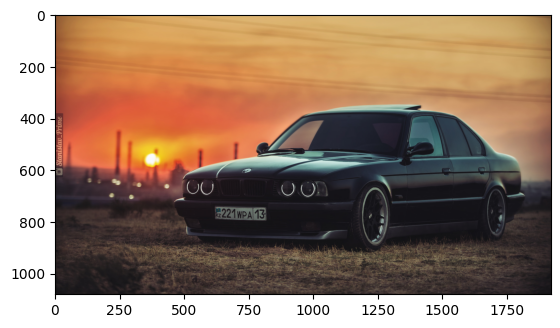

In [42]:
img = Image.open('data/my_images/my_love.jpg')
plt.imshow(img)

resnet.eval() # НЕ ЗАБЫВАТЬ ПЕРЕКЛЮЧАТЬ РЕЖИМ РАБОТЫ МОДЕЛИ!

img_in = transform(img).unsqueeze(dim=0)    # img => transform => (3, 224, 224) => unsqueeze => (1, 3, 224, 224) => img_in
pred = resnet(img_in).squeeze()    # (1, 1000) => (1000)

sorted, indices = pred.softmax(dim=0).sort(descending=True)
for i, (s, ind) in enumerate(zip(sorted, indices)):
    print(f"    {class_names[ind]} => {s:.5f}")
    if i == 5:
        break

In [ ]:
def test_images_on_resnet(image_paths, top_k=5):
    n_images = len(image_paths)
    
    # Создаем сетку n x 2
    fig, axes = plt.subplots(n_images, 2, figsize=(15, 4*n_images))
    if n_images == 1:
        axes = axes.reshape(1, -1)
    
    for i, image_path in enumerate(image_paths):
        try:
            # Загружаем и обрабатываем изображение
            img = Image.open(image_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0)
            
            # Получаем предсказания
            with torch.no_grad():
                predictions = resnet(img_tensor)
                probabilities = torch.softmax(predictions, dim=1)
                top_probs, top_indices = torch.topk(probabilities, top_k, dim=1)
            
            # Сортируем топовые вероятности и индексы по убыванию
            sorted_probs, sort_order = top_probs[0].sort(descending=True)
            sorted_indices = top_indices[0][sort_order]
            sorted_classnames = [class_names[idx] for idx in sorted_indices]
            
            # Отображаем изображение
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f'Изображение {i+1}: {image_path.split("/")[-1]}', fontsize=12)
            axes[i, 0].axis('off')
            
            # Отображаем отсортированный топ-к классов
            bars = axes[i, 1].barh(range(top_k), sorted_probs.numpy())
            axes[i, 1].set_yticks(range(top_k))
            axes[i, 1].set_yticklabels(sorted_classnames, fontsize=10)
            axes[i, 1].set_xlabel('Вероятность', fontsize=10)
            axes[i, 1].set_title(f'Топ-{top_k} предсказаний', fontsize=12)
            axes[i, 1].grid(axis='x', alpha=0.3)
            axes[i, 1].set_xlim(0, 1)  # Ось X от 0 до 1
            
            # Добавляем значения вероятностей на столбцы
            for j, prob in enumerate(sorted_probs):
                axes[i, 1].text(prob.item() + 0.01, j, f'{prob.item():.3f}', 
                               va='center', fontsize=9)
                
        except Exception as e:
            axes[i, 0].text(0.5, 0.5, f'Ошибка загрузки:\n{str(e)}', 
                           ha='center', va='center', transform=axes[i, 0].transAxes)
            axes[i, 0].set_title(f'Ошибка: {image_path}', fontsize=12)
            axes[i, 1].text(0.5, 0.5, 'Нет данных', ha='center', va='center', 
                           transform=axes[i, 1].transAxes)
            axes[i, 1].set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

Тестирование модели ResNet на списке изображений...


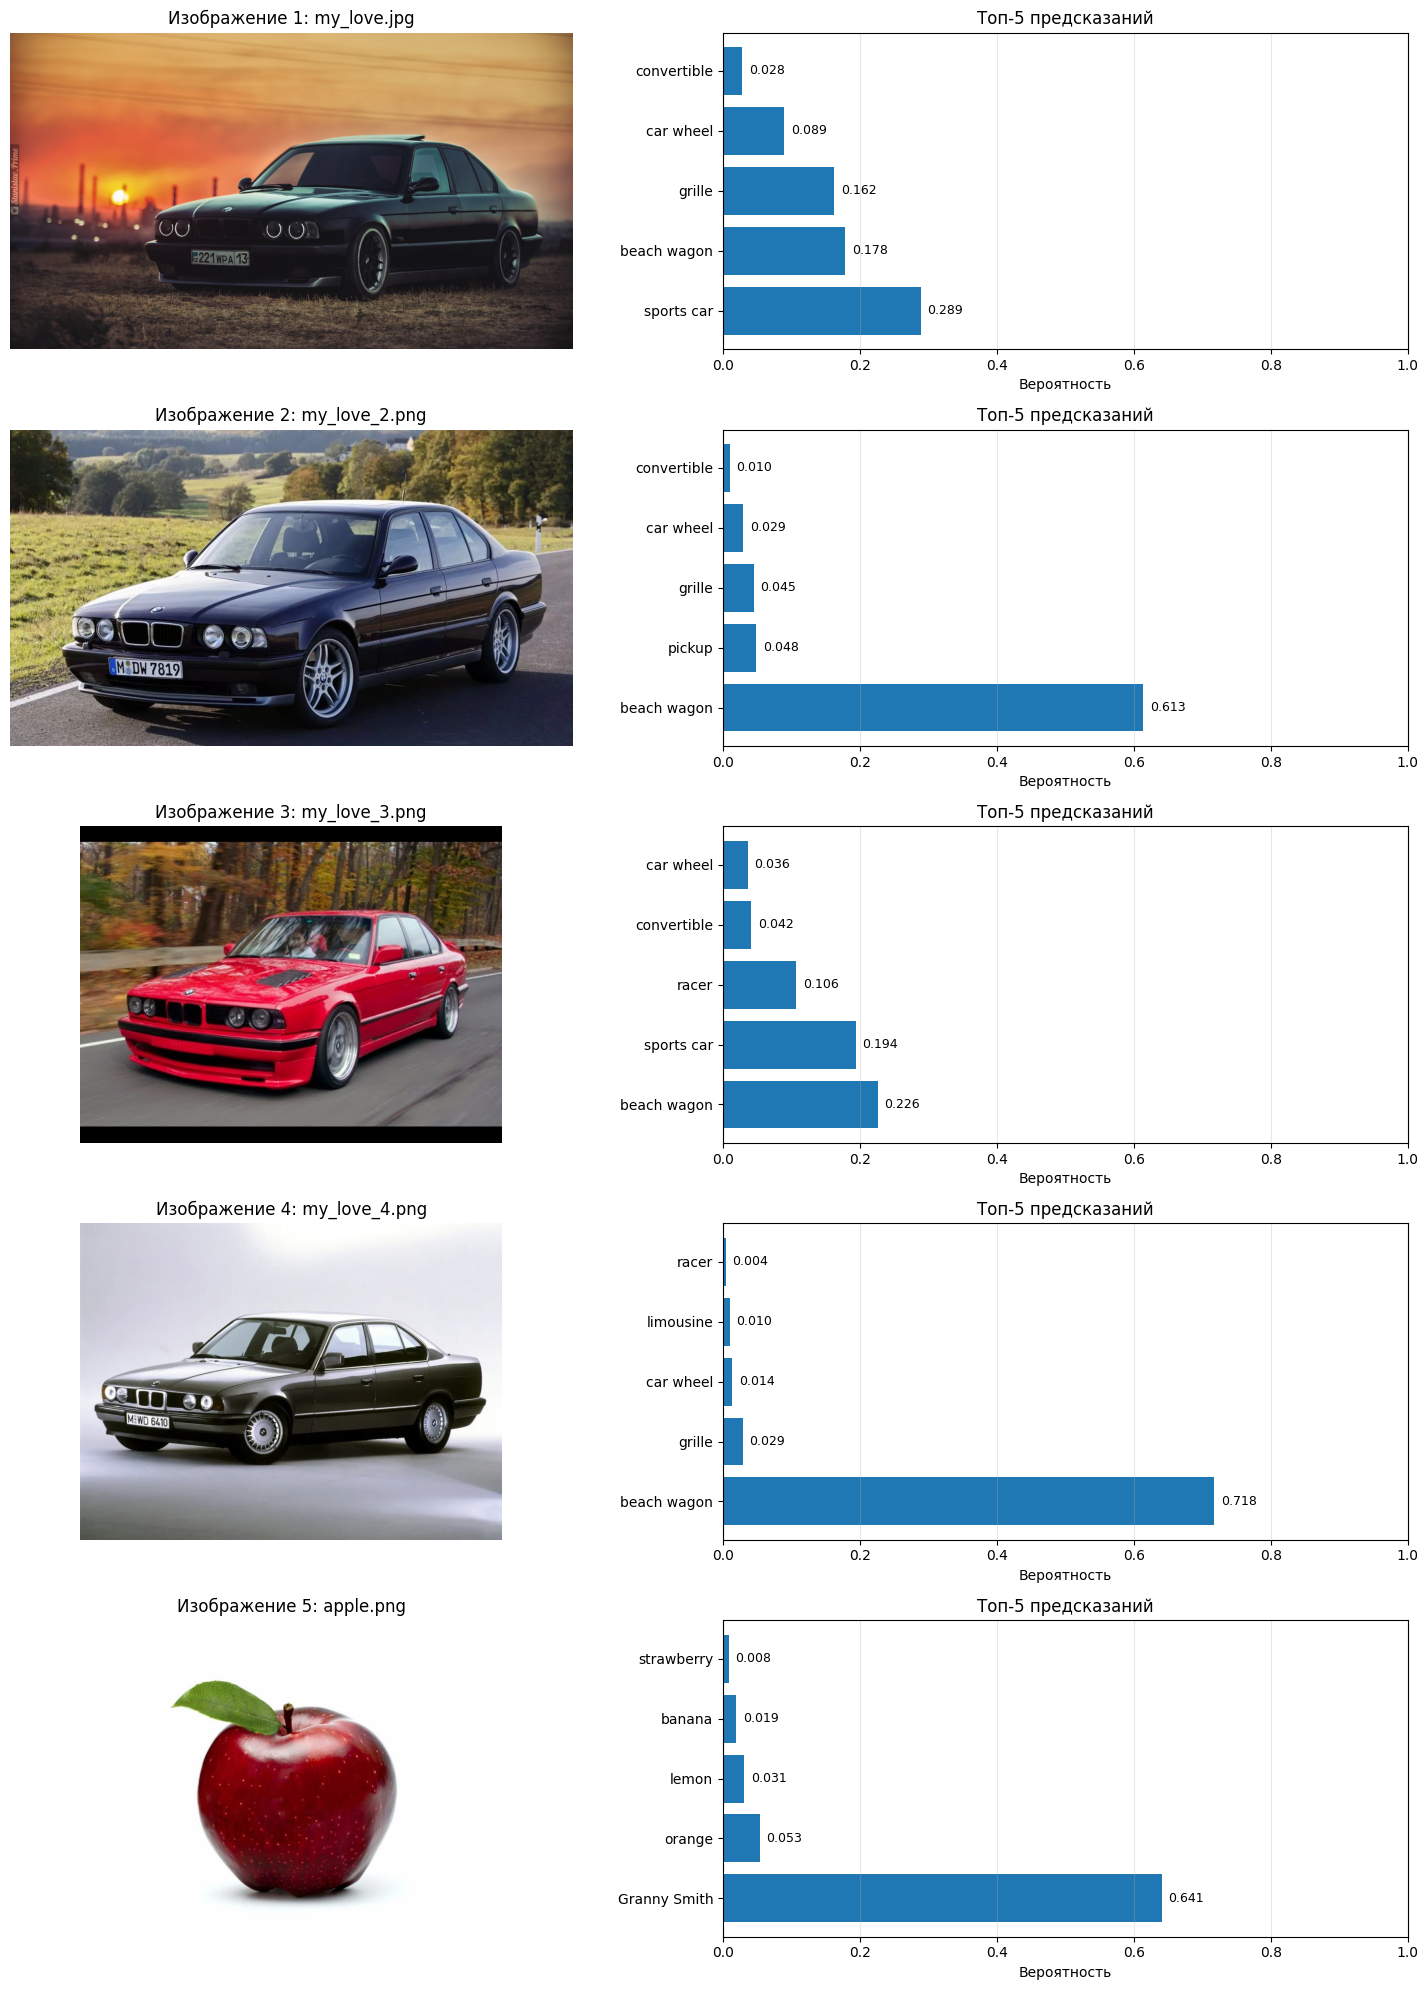

In [60]:
# Список путей к изображениям для тестирования
image_paths = [
    'data/my_images/my_love.jpg',
    'data/my_images/my_love_2.png', 
    'data/my_images/my_love_3.png',
    'data/my_images/my_love_4.png',
    'data/my_images/apple.png'
]

print("Тестирование модели ResNet на списке изображений...")
test_images_on_resnet(image_paths, top_k=5)

***Результаты***:
- > СоМнИтЕлЬнО, нО о'КЭЙ...
- 34-ка, по мнению ResNet, - это ***бич вагон***...
- ResNet спутала яблоко с чьей-то бабушкой *Гранни Смит*...
- **Вывод**: отличная модель, высокий score, отличный fabric, работаем.